# Transfer Learning

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

In [4]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile

# Extract Zip
local_zip = '/content/drive/MyDrive/data/ImageCalssification.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [6]:
data_dir = "/content/ImageCalssification"

def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=100,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 2243 files belonging to 6 classes.
Using 1795 files for training.
Found 2243 files belonging to 6 classes.
Using 448 files for validation.


In [7]:
do_fine_tuning = True

In [8]:
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001), 
                          activation='softmax')
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 2,231,558
Non-trainable params: 34,112
_________________________________________________________________


In [9]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [10]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=25, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/25
112/112 [==============================] - 66s 441ms/step - loss: 1.2379 - accuracy: 0.6685 - val_loss: 1.5839 - val_accuracy: 0.6496
Epoch 2/25
112/112 [==============================] - 50s 440ms/step - loss: 0.9958 - accuracy: 0.7836 - val_loss: 1.2331 - val_accuracy: 0.7366
Epoch 3/25
112/112 [==============================] - 48s 431ms/step - loss: 0.9023 - accuracy: 0.8286 - val_loss: 0.8487 - val_accuracy: 0.8750
Epoch 4/25
112/112 [==============================] - 48s 430ms/step - loss: 0.8300 - accuracy: 0.8600 - val_loss: 0.8721 - val_accuracy: 0.8348
Epoch 5/25
112/112 [==============================] - 48s 432ms/step - loss: 0.8049 - accuracy: 0.8746 - val_loss: 0.8003 - val_accuracy: 0.8906
Epoch 6/25
112/112 [==============================] - 48s 431ms/step - loss: 0.7731 - accuracy: 0.8977 - val_loss: 0.8501 - val_accuracy: 0.8549
Epoch 7/25
112/112 [==============================] - 49s 434ms/step - loss: 0.7441 - accuracy: 0.9050 - val_loss: 0.7735 - val_ac

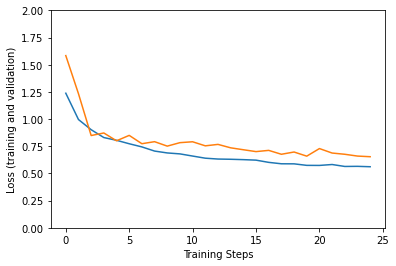

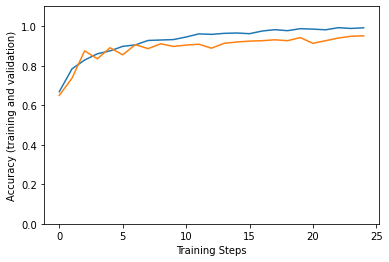

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1.1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

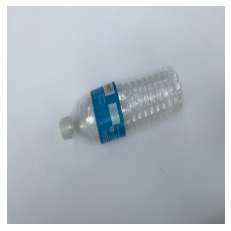

[[0.01244134 0.00605258 0.95084256 0.00838572 0.00742651 0.01485125]]
True label: Botol Plastik
Predicted label: Botol Plastik


In [13]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print(model.predict(np.expand_dims(image, axis=0)))
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [14]:
# Save Model
model.save("waste.h5")

# Convert to TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('waste.tflite', 'wb') as f:
  f.write(tflite_model)

# Create Labels File
with open('labels.txt', 'w') as f:
    f.write('\n'.join('%s' % name for name in class_names))

INFO:tensorflow:Assets written to: /tmp/tmpggjg3gid/assets


INFO:tensorflow:Assets written to: /tmp/tmpggjg3gid/assets


In [15]:
# Download model and label
from google.colab import files
files.download('waste.h5')
files.download('waste.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>